In [1]:
import os
import cv2
import scipy
from scipy.ndimage import sobel, gaussian_filter
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import torch
import torchvision.utils as vutils

In [2]:
def image_aggregation_sobel(images_list, top3=True):
    # First image should be real
    real = images_list[0]
    images_list = images_list[1:]
    if top3:
        # Pick top 3 out of 5 based on PSNR
        psnr_scores = list()
        for i, img in enumerate(images_list):
            psnr_scores.append((i, psnr(real, img)))
        idx = [x[0] for x in sorted(psnr_scores, key=lambda x: x[1], reverse=True)[:3]]
        filtered_images_list = []
        for i in idx:
            filtered_images_list.append(images_list[i])
    else:
        # Consider all images
        filtered_images_list = images_list
    gaussian_sobel_images = list()
    for img in filtered_images_list:
        horizontal = sobel(img, 0)
        vertical = sobel(img, 1)
        sobel_img = np.hypot(horizontal, vertical)
        sobel_img = np.uint8(sobel_img / sobel_img.max() * 255)
        sobel_gaussian_img = gaussian_filter(sobel_img, mode="reflect", sigma=2)
        gaussian_sobel_images.append(sobel_gaussian_img)
    weights = np.array(gaussian_sobel_images / np.sum(gaussian_sobel_images, 0))
    images = np.array(filtered_images_list)
    aggregate_image = (images * weights).sum(0)
    aggregate_image = np.uint8(aggregate_image)
    return aggregate_image

In [3]:
def compute_psnr(real_batch: np.ndarray, fake_batch: np.ndarray) -> float:
    b_size = real_batch.shape[0]
    psnr_val = 0.0
    # fake_batch will only have one batch
    for i in range(b_size):
        psnr_val += psnr(
            real_batch[i, :, :, :].transpose(1, 2, 0),
            fake_batch[0, :, :, :].transpose(1, 2, 0),
            data_range=1.0,
        )
    return psnr_val / b_size

In [4]:
def compute_ssim(real_batch: np.ndarray, fake_batch: np.ndarray) -> float:
    b_size = real_batch.shape[0]
    ssim_val = 0.0
    # fake_batch will only have one batch
    for i in range(b_size):
        ssim_val += ssim(
            real_batch[i, :, :, :],
            fake_batch[0, :, :, :],
            channel_axis=0,
            data_range=1.0,
        )
    return ssim_val / b_size

In [5]:
def image_aggregation_psnr(images_list):
    # First image should be real
    psnr_list = list()
    real = images_list[0]
    for img in images_list[1:]:
        psnr_list.append(psnr(real, img))
    psnr_list = np.array(psnr_list)
    weights = psnr_list/np.sum(psnr_list)
    weights = weights[..., None, None]
    images = np.array(images_list[1:])
    aggregate_image = (images * weights).sum(0)
    aggregate_image = np.uint8(aggregate_image)
    return aggregate_image

In [6]:
def image_aggregation_ssim(images_list):
    # First image should be real
    ssim_list = list()
    real = images_list[0]
    for img in images_list[1:]:
        ssim_list.append(ssim(real, img))
    ssim_list = np.array(ssim_list)
    weights = ssim_list/np.sum(ssim_list)
    weights = weights[..., None, None]
    images = np.array(images_list[1:])
    aggregate_image = (images * weights).sum(0)
    aggregate_image = np.uint8(aggregate_image)
    return aggregate_image

In [7]:
real_folder = "images/t1/real"
dcgan_folder = "images/t1/dcgan"
wgan_folder  = "images/t1/wgan"
wgan_gp_folder = "images/t1/wgan_gp"
unetgan_norm_winit_folder = "images/t1/unetgan/norm"
unetgan_ortho_winit_folder = "images/t1/unetgan/ortho"

In [8]:
fnames = os.listdir(dcgan_folder)

real_images = list()
dcgan_images = list()
wgan_images = list()
wgan_gp_images = list()
unetgan_norm_winit_images = list()
unetgan_ortho_winit_images = list()

for fname in fnames:
    real_images.append(cv2.imread(f"{real_folder}/{fname}", cv2.IMREAD_GRAYSCALE))
    dcgan_images.append(cv2.imread(f"{dcgan_folder}/{fname}", cv2.IMREAD_GRAYSCALE))
    wgan_images.append(cv2.imread(f"{wgan_folder}/{fname}", cv2.IMREAD_GRAYSCALE))
    wgan_gp_images.append(cv2.imread(f"{wgan_gp_folder}/{fname}", cv2.IMREAD_GRAYSCALE))
    unetgan_norm_winit_images.append(cv2.imread(f"{unetgan_norm_winit_folder}/{fname}", cv2.IMREAD_GRAYSCALE))
    unetgan_ortho_winit_images.append(cv2.imread(f"{unetgan_ortho_winit_folder}/{fname}", cv2.IMREAD_GRAYSCALE))

### Aggregate using Sobel weights and store it to disk

In [9]:
agg_images = list()
for images in zip(real_images, dcgan_images, wgan_images, wgan_gp_images, unetgan_norm_winit_images, unetgan_ortho_winit_images):
    agg_images.append(image_aggregation_sobel(images, top3=False))

In [10]:
store_folder = "images/t1/sobel_aggr_all"
# plt.axis("off")
# plt.figure(figsize=(64, 64))
for i, img in enumerate(agg_images):
    # plt.imshow(img, cmap="gray")
    # plt.savefig(f"{store_folder}/{i}.png")
    img = img / 255
    vutils.save_image(torch.Tensor(img), f"{store_folder}/{i}.png")

### Experimenting with Aggregation using sobel and gaussian filter based weighting

<Figure size 6400x6400 with 0 Axes>

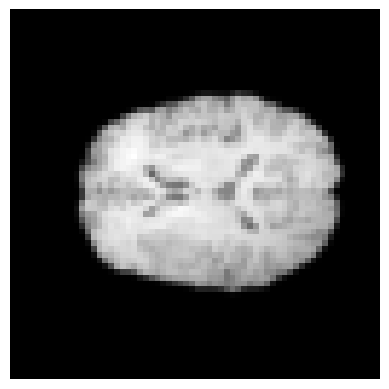

<Figure size 6400x6400 with 0 Axes>

In [11]:
plt.imshow(real_images[0], cmap="gray")
plt.axis("off")
plt.figure(figsize=(64, 64))

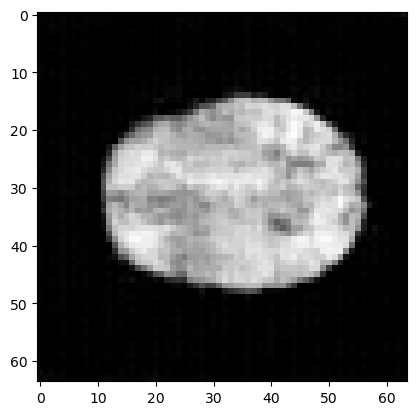

In [12]:
plt.imshow(dcgan_images[0], cmap="gray")

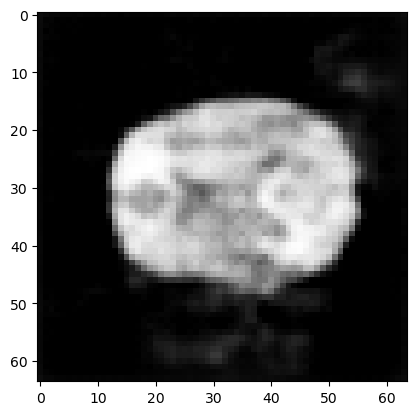

In [13]:
plt.imshow(wgan_images[0], cmap="gray")

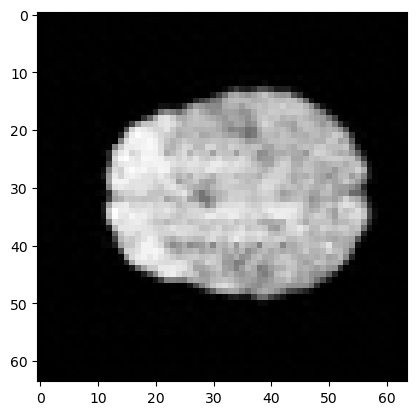

In [14]:
plt.imshow(wgan_gp_images[0], cmap="gray")

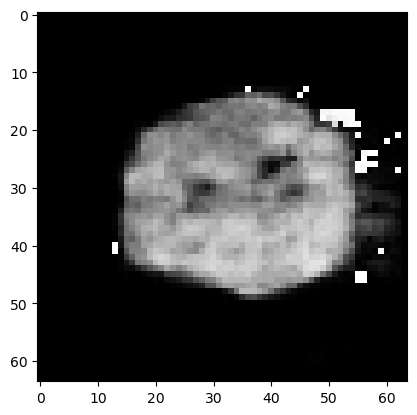

In [15]:
plt.imshow(unetgan_norm_winit_images[0], cmap="gray")

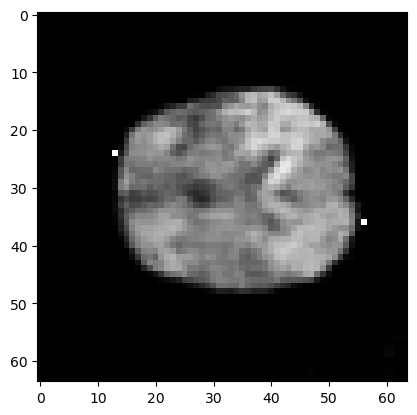

In [16]:
plt.imshow(unetgan_ortho_winit_images[0], cmap="gray")

In [17]:
agg_img = image_aggregation_sobel([dcgan_images[0], wgan_images[0], wgan_gp_images[0], unetgan_norm_winit_images[0], unetgan_ortho_winit_images[0]])

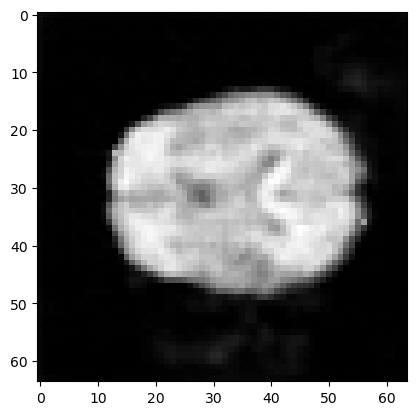

In [18]:
plt.imshow(agg_img, cmap="gray")

### Aggregation using PSNR weighting

In [19]:
agg_img = image_aggregation_psnr([real_images[0], dcgan_images[0], wgan_images[0], wgan_gp_images[0], unetgan_norm_winit_images[0], unetgan_ortho_winit_images[0]])

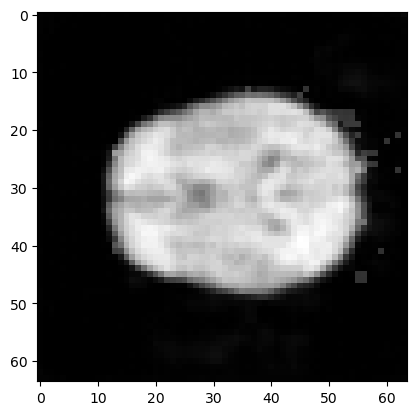

In [20]:
plt.imshow(agg_img, cmap="gray")

### Aggregation using SSIM weighting

In [21]:
agg_img = image_aggregation_ssim([real_images[0], dcgan_images[0], wgan_images[0], wgan_gp_images[0], unetgan_norm_winit_images[0], unetgan_ortho_winit_images[0]])

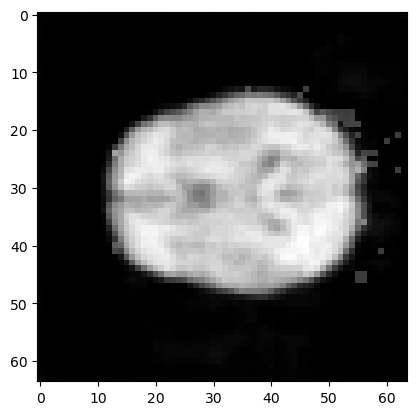

In [22]:
plt.imshow(agg_img, cmap="gray")

## Experimenting with Sobel and Gaussian filters

In [23]:
img = dcgan_images[0]

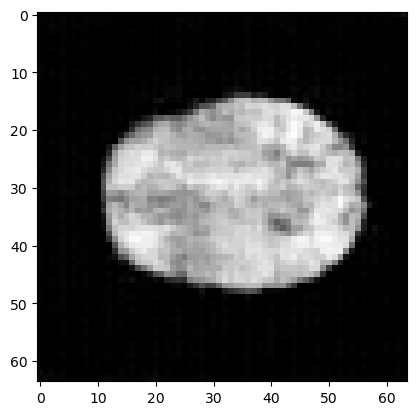

In [24]:
plt.imshow(img, cmap="gray")

In [25]:
horizontal = sobel(img, 0)
vertical = sobel(img, 1)
sobel_img = np.hypot(horizontal, vertical)

In [26]:
sobel_img = np.uint8(sobel_img / sobel_img.max() * 255)

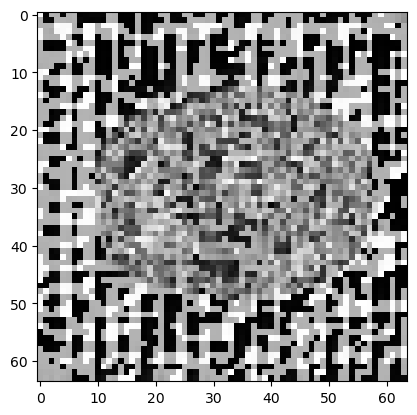

In [27]:
plt.imshow(sobel_img, cmap="gray")

In [28]:
sobel_gaussian_img = gaussian_filter(sobel_img, mode="reflect", sigma=2)

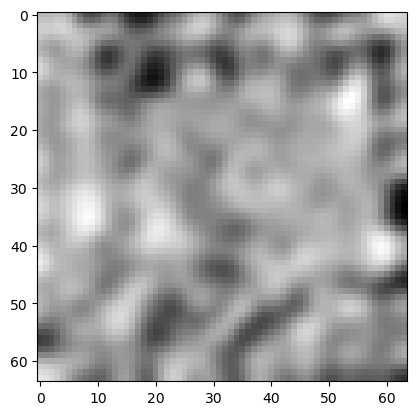

In [29]:
plt.imshow(sobel_gaussian_img, cmap="gray")